In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Input: The 55k list
TRAIN_LIST = "/content/drive/MyDrive/voice_project/balanced_age_list_50plus.csv"

# Paths
FEATURES_PATH = "/content/features_local"
STATS_PATH = "/content/drive/MyDrive/voice_project/scaling_stats"
MODEL_SAVE_PATH = "/content/drive/MyDrive/voice_project/best_age_model_50plus.pth"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
try:
    GLOBAL_MEAN = np.load(os.path.join(STATS_PATH, "global_mean.npy"))
    GLOBAL_STD = np.load(os.path.join(STATS_PATH, "global_std.npy"))
    print(f"Loaded Stats: Mean={GLOBAL_MEAN:.2f}, Std={GLOBAL_STD:.2f}")
except:
    print("Stats not found. Using default.")
    GLOBAL_MEAN, GLOBAL_STD = -59.25, 11.95

Loaded Stats: Mean=-59.25, Std=11.95


In [ ]:
AGE_MAP = {
    'teens': 0,
    'twenties': 1,
    'thirties': 2,
    'fourties': 3,
    '50plus': 4
}
NUM_AGE_CLASSES = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class AgeDataset(Dataset):
    def __init__(self, df, features_dir, mean, std):
        self.data_list = df
        self.features_dir = features_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        row = self.data_list.iloc[idx]

        # Determine filename
        npy_filename = row['path'].replace(".mp3", ".npy")
        file_path = os.path.join(self.features_dir, npy_filename)

        try:
            # Load & Scale
            spectrogram = np.load(file_path)
            norm_spectrogram = (spectrogram - self.mean) / self.std

            # Tensor setup
            spec_tensor = torch.tensor(norm_spectrogram, dtype=torch.float32).unsqueeze(0)
            age_label = torch.tensor(AGE_MAP[row['age']], dtype=torch.long)

            return spec_tensor, age_label
        except:
            # Dummy fallback
            return torch.zeros((1, 128, 216)), torch.tensor(0)

In [ ]:
class AgeCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(AgeCNN, self).__init__()
        # Deeper Body for more complex Age features
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        # Dense Layers
        # 128 channels * 16 height * 27 width = 55296 features
        self.fc1 = nn.Linear(128 * 16 * 27, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn4(self.fc1(x))))
        return self.fc2(x)

In [ ]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm


SOURCE_FEATURES = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
LOCAL_FEATURES = "/content/features_local"

# --- Fast Copy Function ---
def copy_file(filename):
    src_path = os.path.join(SOURCE_FEATURES, filename)
    dst_path = os.path.join(LOCAL_FEATURES, filename)

    # Only copy if it doesn't exist
    if not os.path.exists(dst_path):
        try:
            shutil.copy(src_path, dst_path)
            return 1
        except Exception as e:
            return 0
    return 0

# --- Main Execution ---
print(f"Preparing Turbo Copy from Drive to {LOCAL_FEATURES}...")

if os.path.exists(SOURCE_FEATURES):
    # 1. Create local dir
    os.makedirs(LOCAL_FEATURES, exist_ok=True)

    # 2. List all files (This takes a few seconds)
    print("   Listing files...")
    files = [f for f in os.listdir(SOURCE_FEATURES) if f.endswith('.npy')]
    print(f"   Found {len(files)} feature files.")

    # 3. Parallel Copy
    print(f"   Starting copy with 8 threads...")

    # We use ThreadPoolExecutor which is best for File I/O
    with ThreadPoolExecutor(max_workers=8) as executor:
        # map() runs the function on all files, tqdm shows the bar
        results = list(tqdm(executor.map(copy_file, files), total=len(files), desc="Copying Features"))

    print("\nCopy Complete! Features are on local disk.")

else:
    print(f"Source path not found: {SOURCE_FEATURES}")

🚀 Preparing Turbo Copy from Drive to /content/features_local...
   Listing files...
   Found 61576 feature files.
   Starting copy with 8 threads...


Copying Features:   0%|          | 0/61576 [00:00<?, ?it/s]


✅ Copy Complete! Features are on local disk.


In [ ]:
# Load Main DataFrame
if os.path.exists(TRAIN_LIST):
    full_df = pd.read_csv(TRAIN_LIST)
    print(f"Loaded {len(full_df)} samples.")

    # Split the big list into Train/Val (80/20)
    train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['age'])

    # Create Datasets (Pass DataFrames directly)
    train_ds = AgeDataset(train_df, FEATURES_PATH, GLOBAL_MEAN, GLOBAL_STD)
    val_ds = AgeDataset(val_df, FEATURES_PATH, GLOBAL_MEAN, GLOBAL_STD)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

    print(f" Training on {len(train_ds)} samples")
    print(f" Validating on {len(val_ds)} samples")

    # Init Model
    model = AgeCNN(num_classes=NUM_AGE_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # --- 5. Training Loop ---
    EPOCHS = 20
    best_acc = 0.0

    print("\n Starting Age Model Training...")

    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        running_loss = 0

        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            specs, labels = specs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for specs, labels in val_loader:
                specs, labels = specs.to(device), labels.to(device)
                outputs = model(specs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(" Model Saved!")
else:
    print("Dataset list not found. Make sure previous steps finished!")

Loaded 55051 samples.
 Training on 44040 samples
 Validating on 11011 samples

 Starting Age Model Training...


Epoch 1/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 1: Train Acc=47.48% | Val Acc=60.68%
 Model Saved!


Epoch 2/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 2: Train Acc=66.09% | Val Acc=70.15%
 Model Saved!


Epoch 3/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 3: Train Acc=76.96% | Val Acc=70.19%
 Model Saved!


Epoch 4/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 4: Train Acc=85.56% | Val Acc=75.09%
 Model Saved!


Epoch 5/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 5: Train Acc=91.28% | Val Acc=76.42%
 Model Saved!


Epoch 6/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 6: Train Acc=94.20% | Val Acc=76.03%


Epoch 7/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 7: Train Acc=95.97% | Val Acc=75.93%


Epoch 8/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 8: Train Acc=96.83% | Val Acc=77.85%
 Model Saved!


Epoch 9/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 9: Train Acc=97.02% | Val Acc=76.18%


Epoch 10/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 10: Train Acc=97.38% | Val Acc=77.60%


Epoch 11/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 11: Train Acc=97.84% | Val Acc=77.84%


Epoch 12/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 12: Train Acc=97.92% | Val Acc=76.90%


Epoch 13/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 13: Train Acc=97.99% | Val Acc=77.12%


Epoch 14/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 14: Train Acc=98.29% | Val Acc=78.29%
 Model Saved!


Epoch 15/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 15: Train Acc=98.38% | Val Acc=78.28%


Epoch 16/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 16: Train Acc=98.66% | Val Acc=78.56%
 Model Saved!


Epoch 17/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 17: Train Acc=98.83% | Val Acc=76.90%


Epoch 18/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 18: Train Acc=98.43% | Val Acc=77.42%


Epoch 19/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 19: Train Acc=98.76% | Val Acc=78.03%


Epoch 20/20:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 20: Train Acc=98.93% | Val Acc=77.15%


Testing on 1536 samples from original Test Set...


  0%|          | 0/48 [00:00<?, ?it/s]


Final Test Accuracy: 90.10%
              precision    recall  f1-score   support

       teens       0.93      0.93      0.93       256
    twenties       0.83      0.75      0.79       256
    thirties       0.86      0.86      0.86       256
    fourties       0.90      0.96      0.93       256
      50plus       0.94      0.96      0.95       512

    accuracy                           0.90      1536
   macro avg       0.89      0.89      0.89      1536
weighted avg       0.90      0.90      0.90      1536



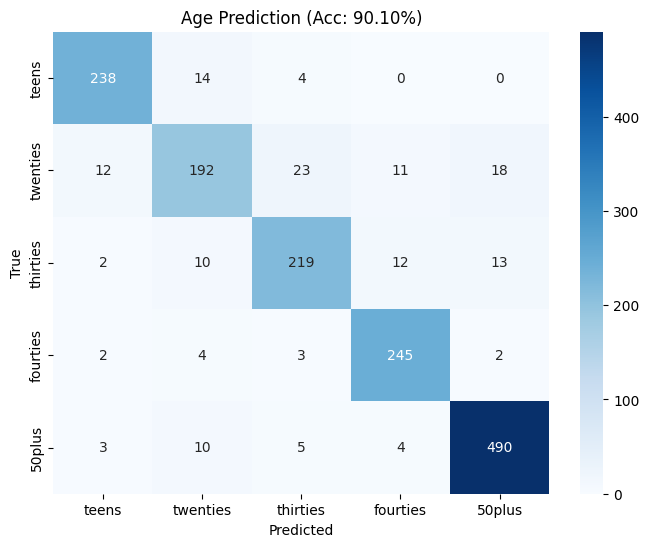

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import librosa
from tqdm.notebook import tqdm

# Config
TEST_LIST_PATH = "/content/drive/MyDrive/voice_project/test_list.csv"
FEATURES_PATH = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"
STATS_PATH = "/content/drive/MyDrive/voice_project/scaling_stats"
MODEL_SAVE_PATH = "/content/drive/MyDrive/voice_project/best_age_model_50plus.pth"

# Load Stats
GLOBAL_MEAN = np.load(os.path.join(STATS_PATH, "global_mean.npy"))
GLOBAL_STD = np.load(os.path.join(STATS_PATH, "global_std.npy"))

# Label Map (Target - what the model predicts)
TARGET_AGE_MAP = {
    'teens': 0, 'twenties': 1, 'thirties': 2, 'fourties': 3, '50plus': 4
}
INV_AGE_MAP = {v: k for k, v in TARGET_AGE_MAP.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Remap Labels
def remap_age_label(age_str):
    # Maps original 6 classes to our new 5 classes
    if age_str in ['fifties', 'sixties', 'seventies', 'eighties', 'nineties', '60plus']:
        return '50plus'
    return age_str

# Dataset Class
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, features_dir, mean, std):
        self.data_list = pd.read_csv(csv_file)
        self.features_dir = features_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        row = self.data_list.iloc[idx]
        npy_filename = row['path'].replace(".mp3", ".npy")
        file_path = os.path.join(self.features_dir, npy_filename)

        try:
            spectrogram = np.load(file_path)
            norm_spectrogram = (spectrogram - self.mean) / self.std
            spec_tensor = torch.tensor(norm_spectrogram, dtype=torch.float32).unsqueeze(0)


            mapped_age = remap_age_label(row['age'])
            age_label = torch.tensor(TARGET_AGE_MAP[mapped_age], dtype=torch.long)

            return spec_tensor, age_label
        except:
            return torch.zeros((1, 128, 216)), torch.tensor(0)

# Model Architecture
class AgeCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(AgeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 27, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(torch.nn.functional.relu(self.bn4(self.fc1(x))))
        return self.fc2(x)

# --- Run Test ---
test_ds = TestDataset(TEST_LIST_PATH, FEATURES_PATH, GLOBAL_MEAN, GLOBAL_STD)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print(f"Testing on {len(test_ds)} samples from original Test Set...")

model = AgeCNN(num_classes=5).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for specs, labels in tqdm(test_loader):
        specs = specs.to(device)
        outputs = model(specs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.numpy())

# Results
acc = 100 * (np.array(all_preds) == np.array(all_true)).mean()
print(f"\nFinal Test Accuracy: {acc:.2f}%")

# Confusion Matrix
target_names = list(TARGET_AGE_MAP.keys())
print(classification_report(all_true, all_preds, target_names=target_names))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Age Prediction (Acc: {acc:.2f}%)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()